# Predictions on different data quality

## Parameters and model

In [3]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn
from metrics.utils import MetricLevel, DefectsScale, DefectsSource
from predictions.prediction import PredictionModel

time_series_start = 0
time_series_end = 180
column = SeriesColumn.CLOSE
stock = StockMarketSeries("Apple", "../data/apple.csv", time_series_start, time_series_end)

## Data - one price column

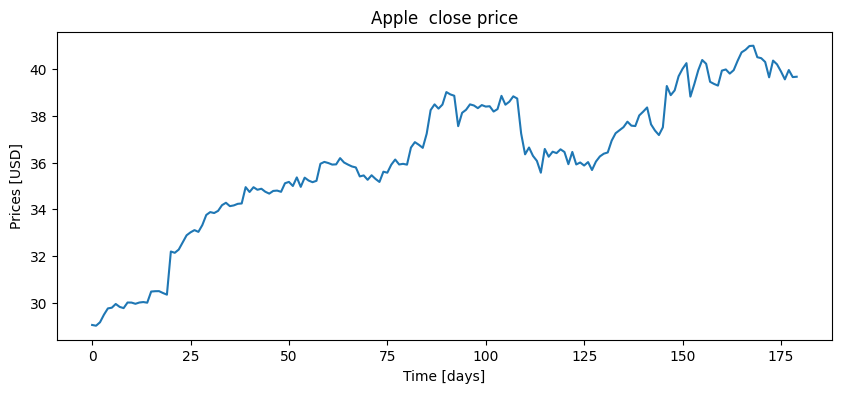

In [2]:
stock.plot_single_series(stock.real_series[column], column)

### Defected data and its quality

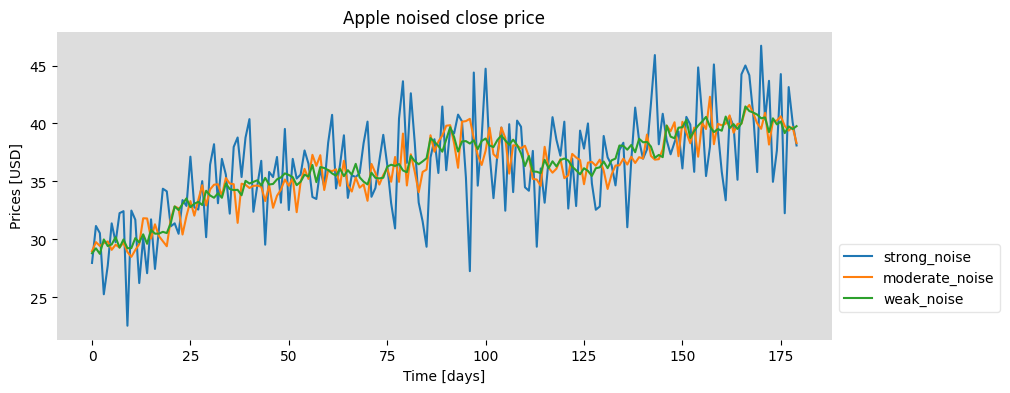

In [3]:
stock.plot_multiple_series("noised close price",
                           strong_noise=stock.all_defected_series[DefectsSource.NOISE][DefectsScale.HIGHLY][column],
                           moderate_noise=stock.all_defected_series[DefectsSource.NOISE][DefectsScale.MODERATELY][
                               column],
                           weak_noise=stock.all_defected_series[DefectsSource.NOISE][DefectsScale.SLIGHTLY][column])

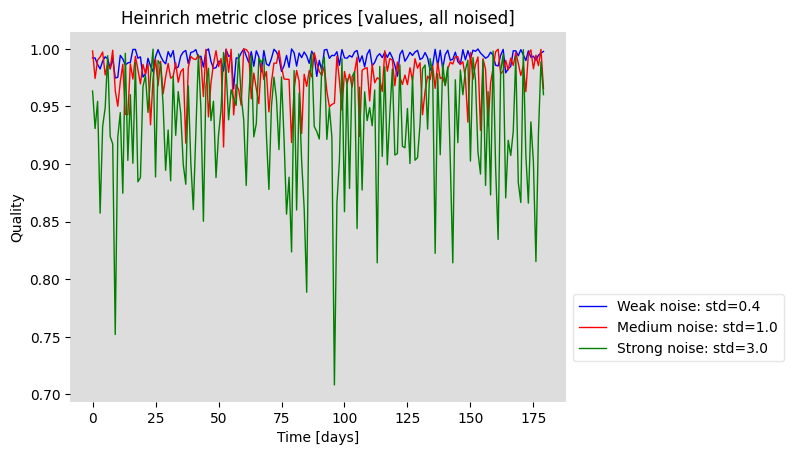

In [4]:
from metrics.correctness import HeinrichCorrectnessMetric

heinrich = HeinrichCorrectnessMetric(stock, alpha={column: 2.1})
weak, moderate, strong = heinrich.values_qualities(column, is_alpha=False)
heinrich.draw_heinrich_qualities(weak, moderate, strong, MetricLevel.VALUES, is_alpha=False,
                                 column_name=column)

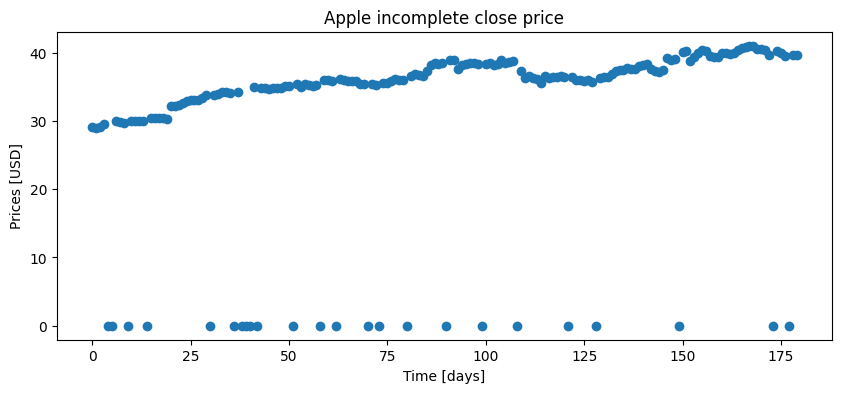

In [5]:
incomplete_data = stock.all_defected_series[DefectsSource.INCOMPLETENESS][DefectsScale.MODERATELY][
    column]
stock.plot_single_series(incomplete_data, column, defection="incomplete", plot_type="o")

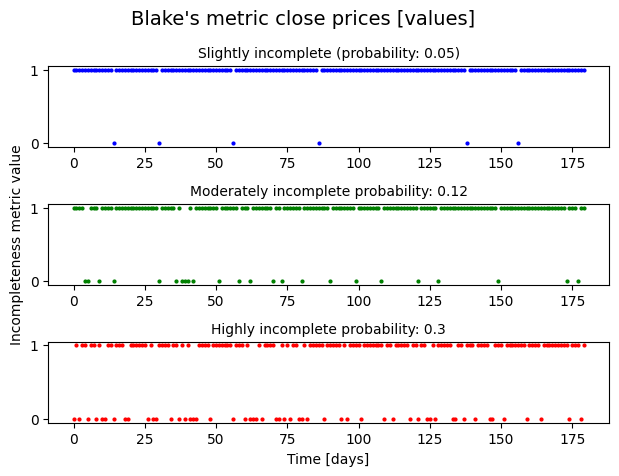

In [6]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities_first, qualities_second, qualities_third = blake.values_qualities(column)
blake.draw_blake(qualities_first, qualities_second, qualities_third, MetricLevel.VALUES, column_name=column)

## Predictions parameters

In [5]:
prediction_start = 150
iterations = 2

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [8]:
from arima import ManualArima

arima_type = ManualArima

## AR(5)

In [9]:
arima = model.create_model(arima_type, p=5, q=0)

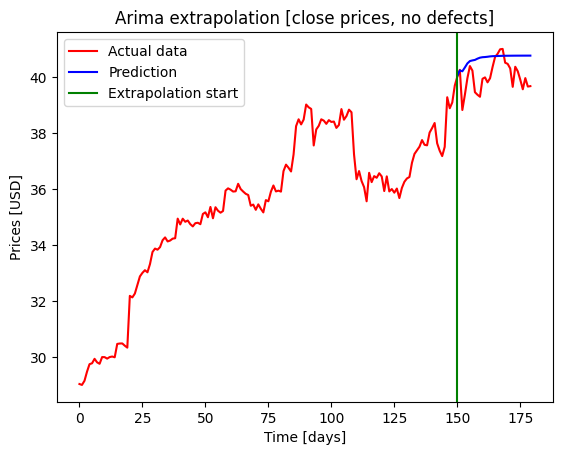

RMS: 0.783 


In [10]:
%%capture --no-stdout --no-display
arima.present_prediction()

In [11]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Apple stock, close price, 2 iterations]

   Defects source Defects scale Avg elapsed time [ms] Std dev elapsed time  \
0            none          none                1264.5            54.447222   
1           noise      slightly                  1104            66.468037   
2           noise    moderately                 938.5            57.275649   
3           noise        highly                1802.5            20.506097   
4  incompleteness      slightly                1939.5            82.731493   
5  incompleteness    moderately                  1435            18.384776   
6  incompleteness        highly                1676.5             3.535534   

  Avg RMS Std dev RMS  
0   0.783         0.0  
1    0.59         0.0  
2   1.648         0.0  
3   5.381         0.0  
4   8.371         0.0  
5  12.406         0.0  
6  17.978         0.0  


## ARIMA(5,1,5)

In [12]:
arima = model.create_model(arima_type, p=5, q=2)

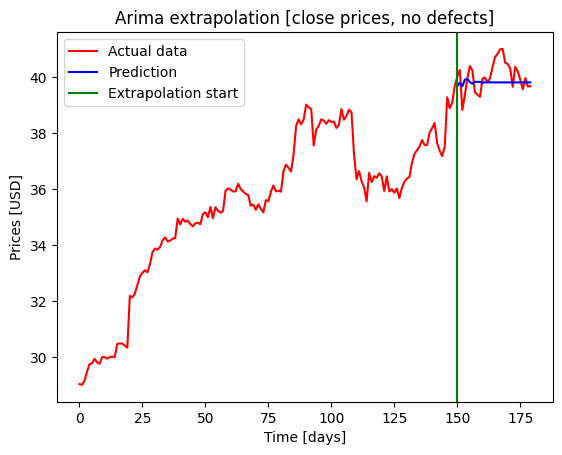

RMS: 0.56 


In [13]:
%%capture --no-stdout --no-display
arima.present_prediction()

In [14]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Apple stock, close price, 2 iterations]

   Defects source Defects scale Avg elapsed time [ms] Std dev elapsed time  \
0            none          none                  5252           114.551299   
1           noise      slightly                  2165             7.071068   
2           noise    moderately                3550.5            13.435029   
3           noise        highly                  5670            80.610173   
4  incompleteness      slightly                  5623           101.823376   
5  incompleteness    moderately                  6697           181.019336   
6  incompleteness        highly                3966.5            13.435029   

  Avg RMS Std dev RMS  
0    0.56         0.0  
1   0.622         0.0  
2   1.625         0.0  
3   4.042         0.0  
4   7.653         0.0  
5  12.462         0.0  
6  17.804         0.0  


## Reservoir computing

In [22]:
from predictions.ml import Reservoir

reservoir = model.create_model(Reservoir)

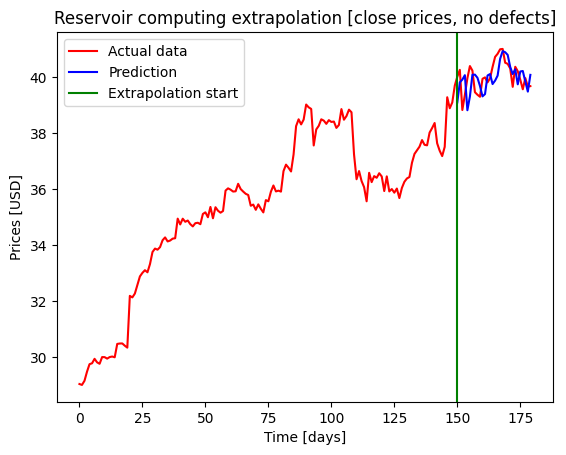

RMS: 0.712 


In [25]:
reservoir.present_prediction()

In [26]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 13).

## XGBoost

In [6]:
from ml import XGBoost

xgboost = model.create_model(XGBoost, optimize=True)

In [ ]:
xgboost.present_prediction()

In [7]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Best score: 113534.27438288213
Best param values: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 1.0, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
Best score: 113534.27438288213
Best param values: {'max_depth': 5, 'n_estimators': 15, 'learning_rate': 1.0, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
Best score: 253040.09422743545
Best param values: {'max_depth': 4, 'n_estimators': 54, 'learning_rate': 0.7785786619013949, 'reg_alpha': 4.055255916347707e-05, 'reg_lambda': 0.04059552587323265}
Best score: 253040.09422743545
Best param values: {'max_depth': 4, 'n_estimators': 54, 'learning_rate': 0.7785786619013949, 'reg_alpha': 4.055255916347707e-05, 'reg_lambda': 0.04059552587323265}
Best score: 448434.049465775
Best param values: {'max_depth': 4, 'n_estimators': 83, 'learning_rate': 0.07636536181789604, 'reg_alpha': 1e-05, 'reg_lambda': 0.05205108259185333}
Best score: 448434.049465775
Best param values: {'max_depth': 4, 'n_estimators': 83, 'learning_rate': 0.07636536181789604, 'reg_alph

KeyboardInterrupt: 